**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

**Load Dataset**

In [ ]:
Dataset = pd.read_csv('/content/jm1_csv.csv')
print("Dataset Shape:", Dataset.shape)
print(Dataset.head())

Dataset Shape: (10885, 22)
     loc  v(g)  ev(g)  iv(g)      n        v     l      d       i         e  \
0    1.1   1.4    1.4    1.4    1.3     1.30  1.30   1.30    1.30      1.30   
1    1.0   1.0    1.0    1.0    1.0     1.00  1.00   1.00    1.00      1.00   
2   72.0   7.0    1.0    6.0  198.0  1134.13  0.05  20.31   55.85  23029.10   
3  190.0   3.0    1.0    3.0  600.0  4348.76  0.06  17.06  254.87  74202.67   
4   37.0   4.0    1.0    4.0  126.0   599.12  0.06  17.19   34.86  10297.30   

   ...  lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
0  ...       2          2        2                  2      1.2        1.2   
1  ...       1          1        1                  1      1.0        1.0   
2  ...      51         10        8                  1     17.0       36.0   
3  ...     129         29       28                  2     17.0      135.0   
4  ...      28          1        6                  0     11.0       16.0   

   total_Op  total_Opnd  branchCoun

**Data Preprocessing**

In [ ]:
Dataset = Dataset.drop_duplicates()
print("Shape after removing duplicates:", Dataset.shape)
Dataset['defects'] = Dataset['defects'].map({True: 1, False: 0})

print("Missing Values Before Imputation:\n", Dataset.isnull().sum())

imputer = SimpleImputer(strategy='mean')
X = Dataset.drop('defects', axis=1)
y = Dataset['defects']
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print("Missing Values After Imputation:\n", X.isnull().sum())

skewed_features = ['loc', 'v', 'e']
for feature in skewed_features:
    X[feature] = np.log1p(X[feature])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

Shape after removing duplicates: (8912, 22)
Missing Values Before Imputation:
 loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              5
uniq_Opnd            5
total_Op             5
total_Opnd           5
branchCount          5
defects              0
dtype: int64
Missing Values After Imputation:
 loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0


<ipython-input-22-98919535c3af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dataset['defects'] = Dataset['defects'].map({True: 1, False: 0})


**Visualizations**

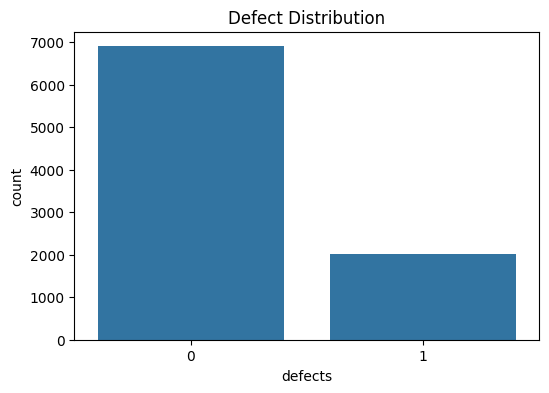

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='defects', data=Dataset)
plt.title('Defect Distribution')
plt.show()

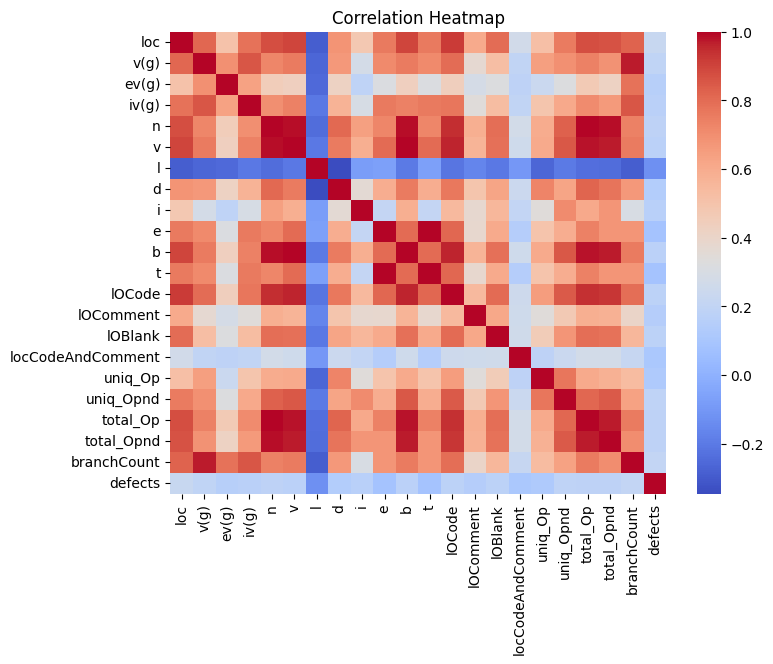

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(Dataset.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

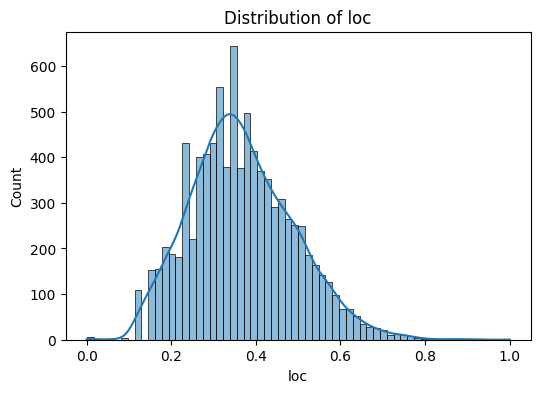

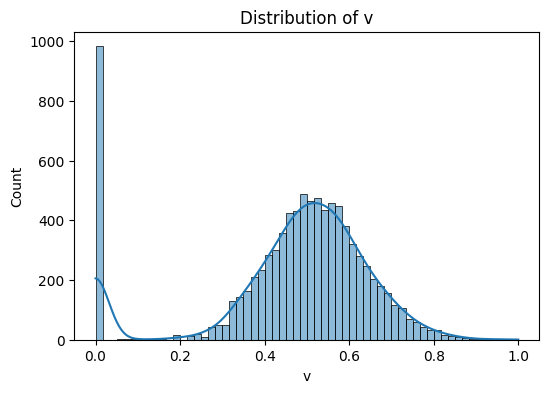

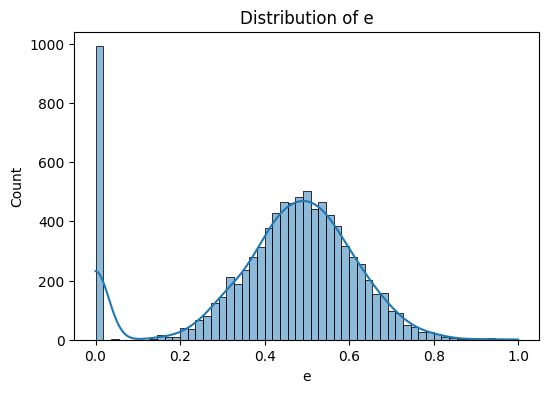

In [ ]:
for col in ['loc', 'v', 'e']:
    plt.figure(figsize=(6, 4))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

**Balancing Dataset with SMOTE**

In [ ]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Shape after SMOTE:", X_balanced.shape)

Shape after SMOTE: (13810, 21)


**Selection with RFE**

In [ ]:
rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=15)
X_selected = rfe.fit_transform(X_balanced, y_balanced)
selected_features = X_balanced.columns[rfe.support_]
print("Selected Features:", selected_features)
X_balanced = pd.DataFrame(X_selected, columns=selected_features)

Selected Features: Index(['loc', 'v(g)', 'iv(g)', 'v', 'd', 'i', 'e', 't', 'lOCode', 'lOBlank',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')


**Split data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

**Model Building**

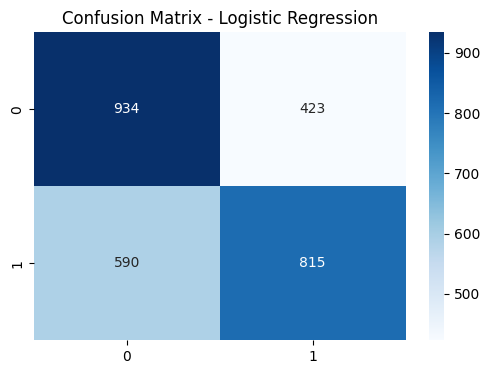

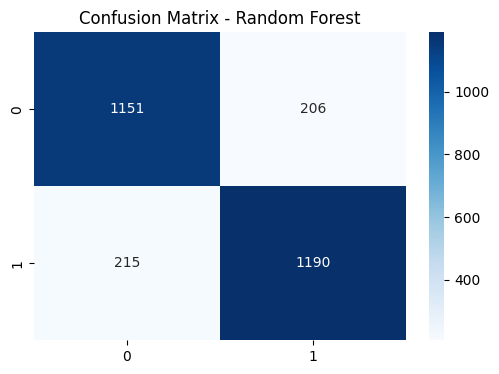

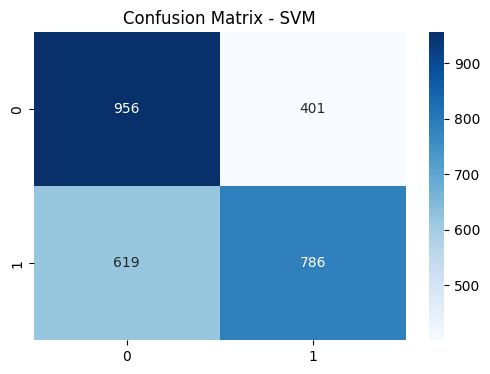

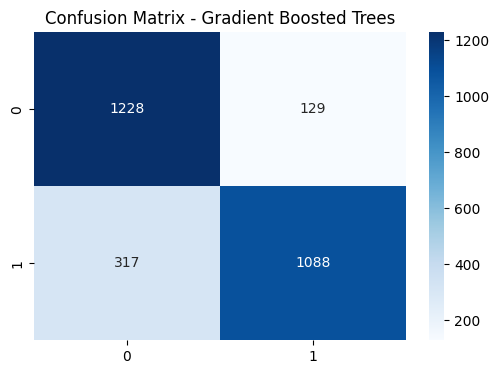

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:32:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


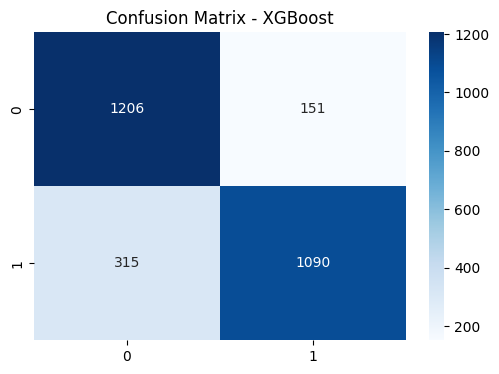

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Gradient Boosted Trees': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'SVM': {'C': [1, 10], 'kernel': ['rbf']},
    'Gradient Boosted Trees': {'n_estimators': [100], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]}
}

results = {}
for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]


    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Best Params': grid.best_params_
    }


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [ ]:
results_df = pd.DataFrame(results).T
print("Model Performance:\n", results_df)

Model Performance:
                         Accuracy Precision    Recall  F1-Score   ROC AUC  \
Logistic Regression     0.633237   0.65832  0.580071  0.616723  0.684647   
Random Forest           0.847574  0.852436  0.846975  0.849697  0.918186   
SVM                     0.630702  0.662174  0.559431  0.606481  0.683724   
Gradient Boosted Trees  0.838523  0.894002  0.774377  0.829901  0.903552   
XGBoost                 0.831282  0.878324  0.775801  0.823885  0.905723   

                                                              Best Params  
Logistic Regression                                             {'C': 10}  
Random Forest                      {'max_depth': 20, 'n_estimators': 200}  
SVM                                            {'C': 10, 'kernel': 'rbf'}  
Gradient Boosted Trees  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...  
XGBoost                 {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...  


In [ ]:
best_model = results_df['F1-Score'].idxmax()
print(f"Best Model: {best_model}")

Best Model: Random Forest


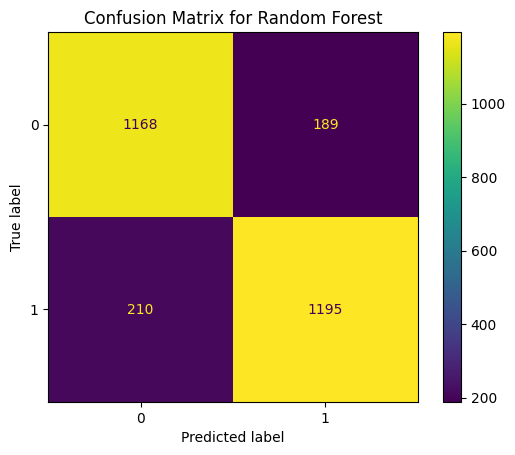

In [ ]:
best_model_obj = models[best_model].fit(X_train, y_train)
y_pred = best_model_obj.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for {best_model}')
plt.show()


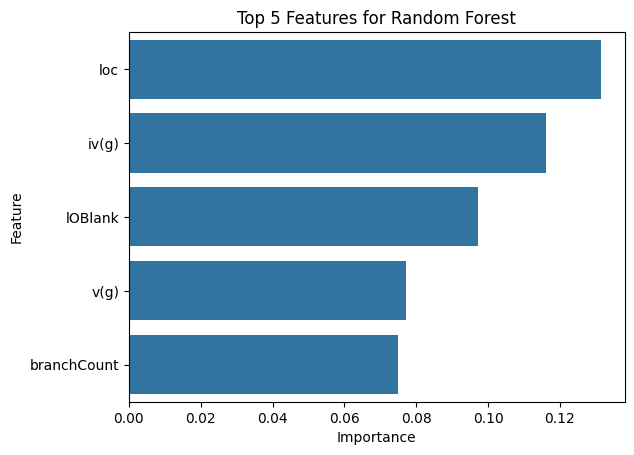

In [ ]:
if best_model in ['Random Forest', 'Gradient Boosted Trees', 'XGBoost']:
    feature_importance = best_model_obj.feature_importances_
    importance_df = pd.DataFrame({'Feature': X_balanced.columns, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False).head(5)
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Top 5 Features for {best_model}')
    plt.show()